see `mpf_rsi_demo.py`

In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import pandas as pd

import numpy as np

import mplfinance as mpf

In [3]:
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

def _ta_RSI(df, n=14):
    # https://github.com/wgong/mplfinance/blob/master/examples/rsi.py
#     diff = df.Close.diff().values
    diff = df.w_p.diff().values
    gains = diff
    losses = -diff
    with np.errstate(invalid='ignore'):
        gains[(gains<0)|np.isnan(gains)] = 0.0
        losses[(losses<=0)|np.isnan(losses)] = 1e-10 # we don't want divide by zero/NaN
    m = (n-1) / n
    ni = 1 / n
    g = gains[n] = np.nanmean(gains[:n])
    l = losses[n] = np.nanmean(losses[:n])
    gains[:n] = losses[:n] = np.nan
    for i,v in enumerate(gains[n:],n):
        g = gains[i] = ni*v + m*g
    for i,v in enumerate(losses[n:],n):
        l = losses[i] = ni*v + m*l
    rs = gains / losses
#     df['rsi'] = 100 - (100/(1+rs))
    return 100 - (100/(1+rs))

In [4]:
infile = "data/yahoofinance-AAPL-20040819-20180120.csv"  # 'data/yahoofinance-SPY-20200901-20210113.csv'
# (3379, 6)
# df = pd.read_csv(infile, index_col=0, parse_dates=True)

df = pd.read_csv(infile, index_col=0, parse_dates=True).iloc[-400:]


In [5]:
df.shape

(400, 6)

In [6]:
RSI_PERIOD = 20

In [7]:
df["w_p"] = 0.25*(2*df['Close'] + df['High'] + df['Low'])

In [8]:
df['rsi'] = relative_strength(df['w_p'],n=RSI_PERIOD)

df['rsi_2'] = _ta_RSI(df,n=RSI_PERIOD)

In [9]:
df['rsi_40'] = _ta_RSI(df,n=40)
df['rsi_80'] = _ta_RSI(df,n=80)
df['rsi_120'] = _ta_RSI(df,n=120)

In [10]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,w_p,rsi,rsi_2,rsi_40,rsi_80,rsi_120
Date,,,,,,,,,,,,
2018-01-05,173.440002,175.369995,173.050003,175.000000,175.000000,23660000,174.605000,58.059310,58.059310,57.928045,58.193259,58.618885
2018-01-08,174.350006,175.610001,173.929993,174.350006,174.350006,20567800,174.560001,57.946444,57.946444,57.873923,58.165314,58.599194
2018-01-09,174.550003,175.059998,173.410004,174.330002,174.330002,21584000,174.282501,57.224305,57.224305,57.533926,57.991404,58.477032
2018-01-10,173.160004,174.300003,173.000000,174.289993,174.289993,23959900,173.969997,56.391249,56.391249,57.146163,57.794343,58.338921
2018-01-11,174.589996,175.490005,174.490005,175.279999,175.279999,18667700,175.135002,58.747864,58.747864,58.222751,58.328916,58.705562
2018-01-12,176.179993,177.360001,175.649994,177.089996,177.089996,25418100,176.797497,61.845100,61.845100,59.704401,59.077930,59.221983
2018-01-16,177.899994,179.389999,176.139999,176.190002,176.190002,29565900,176.977500,62.168825,62.168825,59.862480,59.158420,59.277586
2018-01-17,176.149994,179.250000,175.070007,179.100006,179.100006,34386800,178.130005,64.215092,64.215092,60.870515,59.672708,59.632969
2018-01-18,179.369995,180.100006,178.250000,179.259995,179.259995,31193400,179.217499,66.039602,66.039602,61.799011,60.152173,59.965413


## Compare two RSI functions

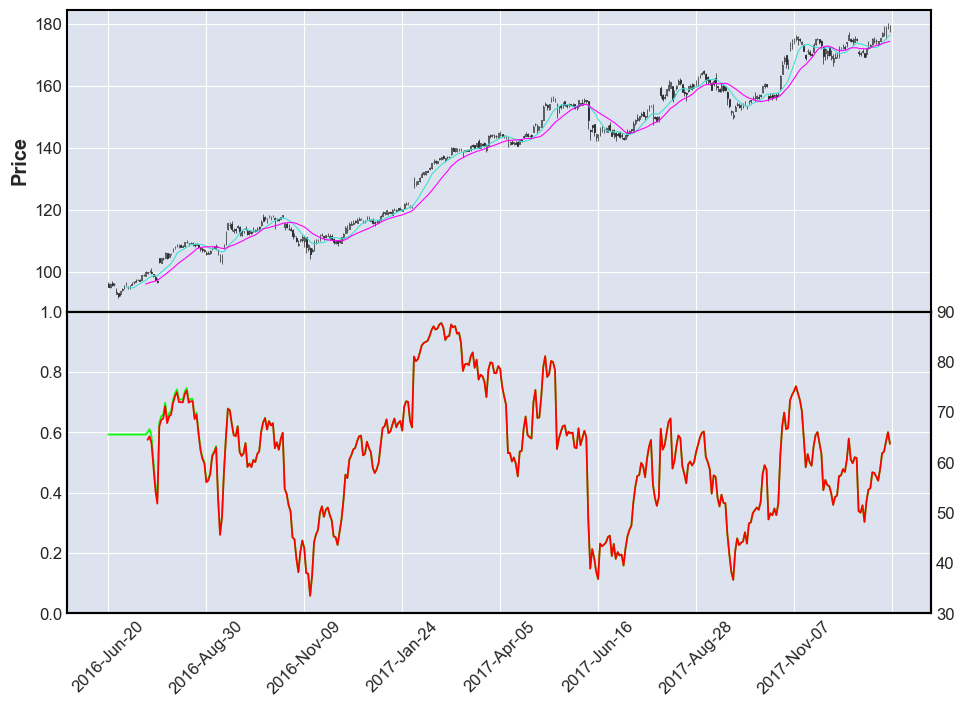

In [11]:
apd = mpf.make_addplot(df['rsi'],panel=1,color='lime',ylim=(30,90),secondary_y=True)
apd_2 = mpf.make_addplot(df['rsi_2'],panel=1,color='red',ylim=(30,90),secondary_y=True)
mpf.plot(df,type='candle',volume=False,mav=(10,20),figscale=1.5,addplot=[apd,apd_2],panel_ratios=(1,1))

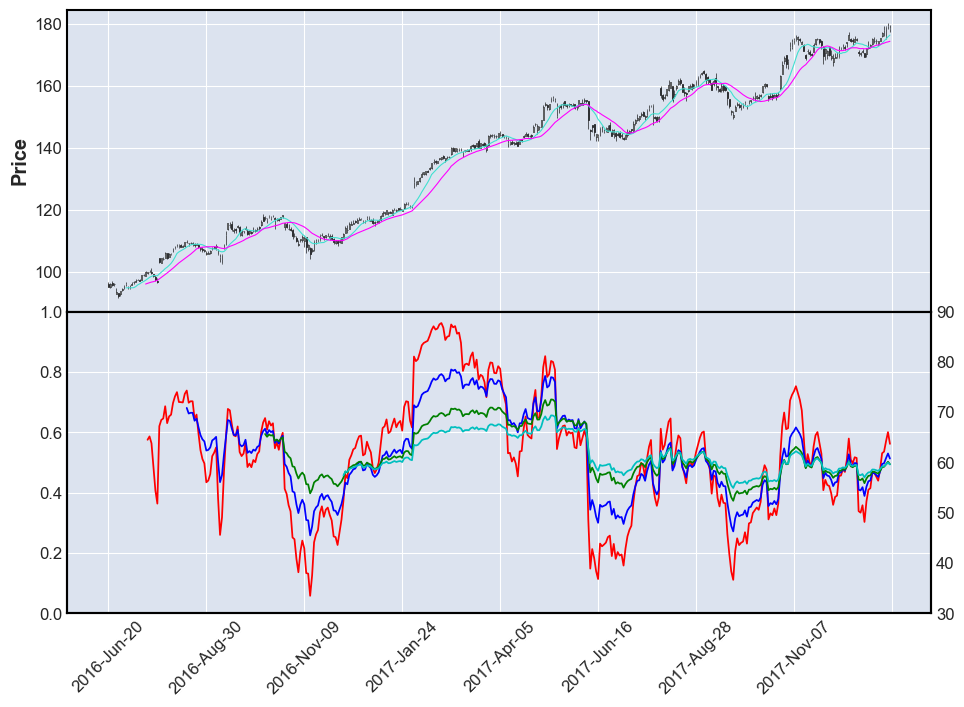

In [12]:
apd_2 = mpf.make_addplot(df['rsi_2'],panel=1,color='r',ylim=(30,90),secondary_y=True)
apd_40 = mpf.make_addplot(df['rsi_40'],panel=1,color='b',ylim=(30,90),secondary_y=True)
apd_80 = mpf.make_addplot(df['rsi_80'],panel=1,color='g',ylim=(30,90),secondary_y=True)
apd_120 = mpf.make_addplot(df['rsi_120'],panel=1,color='c',ylim=(30,90),secondary_y=True)
mpf.plot(df,type='candle',volume=False,mav=(10,20),figscale=1.5,
         addplot=[apd_2,apd_40,apd_80,apd_120],
         panel_ratios=(1,1))

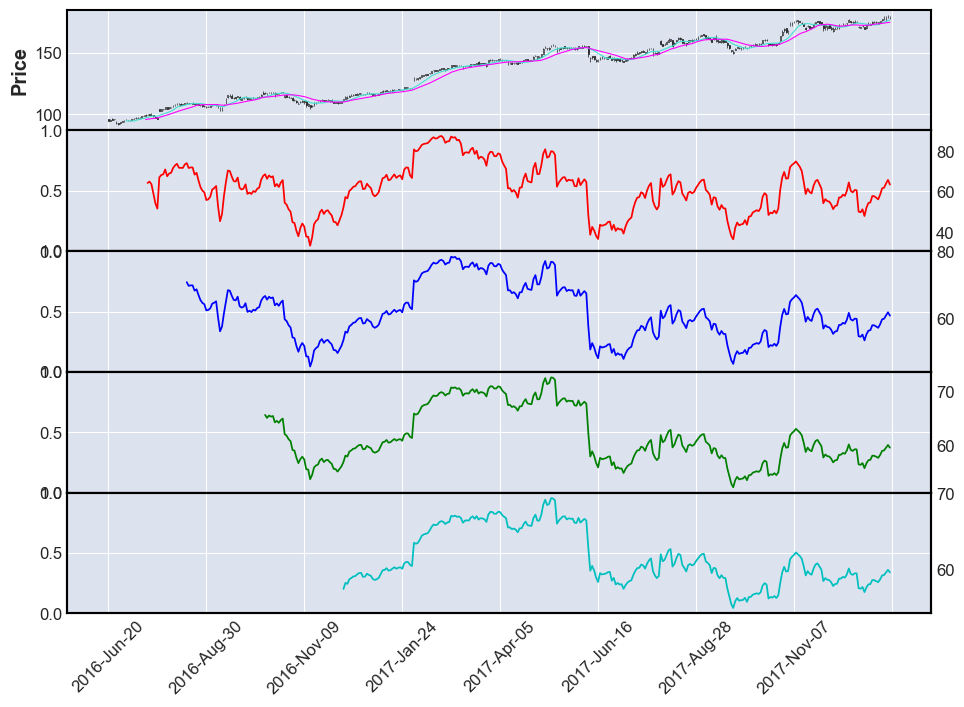

In [13]:
apd_2 = mpf.make_addplot(df['rsi_2'],panel=1,color='r',secondary_y=True)
apd_40 = mpf.make_addplot(df['rsi_40'],panel=2,color='b',secondary_y=True)
apd_80 = mpf.make_addplot(df['rsi_80'],panel=3,color='g',secondary_y=True)
apd_120 = mpf.make_addplot(df['rsi_120'],panel=4,color='c',secondary_y=True)
mpf.plot(df,type='candle',volume=False,mav=(10,20),figscale=1.5,
         addplot=[apd_2,apd_40,apd_80,apd_120],
         panel_ratios=(1,1,1,1,1))

It seems that RSI_PERIOD = 80 represents long-term trend well!  EMA=20 for fast trend

## profile two functions

In [14]:
%%timeit
df['rsi'] = relative_strength(df['w_p'],n=RSI_PERIOD)  
# 548 µs ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)   90 rows

# 1.75 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each) 400 rows

1.92 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%%timeit
df['rsi_2'] = _ta_RSI(df,n=RSI_PERIOD)
# 1.05 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)    90 rows

# 1.45 ms ± 40.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)   400 rows

1.15 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
df['rsi']

Date
2016-06-20    65.567645
2016-06-21    65.567645
2016-06-22    65.567645
2016-06-23    65.567645
2016-06-24    65.567645
                ...    
2018-01-12    61.845100
2018-01-16    62.168825
2018-01-17    64.215092
2018-01-18    66.039602
2018-01-19    63.712846
Name: rsi, Length: 400, dtype: float64

In [17]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,w_p,rsi,rsi_2,rsi_40,rsi_80,rsi_120
Date,,,,,,,,,,,,
2016-06-20,96.000000,96.570000,95.029999,95.099998,92.615105,34411900,95.449999,65.567645,NaN,NaN,NaN,NaN
2016-06-21,94.940002,96.349998,94.680000,95.910004,93.403946,35546400,95.712502,65.567645,NaN,NaN,NaN,NaN
2016-06-22,96.250000,96.889999,95.349998,95.550003,93.053352,29219100,95.835001,65.567645,NaN,NaN,NaN,NaN
2016-06-23,95.940002,96.290001,95.250000,96.099998,93.588974,32240200,95.934999,65.567645,NaN,NaN,NaN,NaN
2016-06-24,92.910004,94.660004,92.650002,93.400002,90.959526,75311400,93.527502,65.567645,NaN,NaN,NaN,NaN


In [18]:
np.nanmin(df['rsi']), np.nanmax(df['rsi'])

(33.51866024835107, 87.72826712258428)